In [1]:
from newick import loads
import newick
from DNASkittleUtils.DDVUtils import pp
import csv

In [13]:
all_trees = {}
with open(r"CAFE-4.2\data\homeologs_only\simulated\reports\simulation_viterbi.cafe", 'r') as csvfile:
    lines = csvfile.readlines()[10:]
    for nLines, row in enumerate(lines):
        row = row.split('\t')
        all_trees[int(row[0])] = row[1]
len(all_trees)

8484

In [14]:
all_homeologs = list(all_trees.keys())
ordered_names = loads('((((((((((FRAX30:2,FRAX32:2)<1>:1,FRAX28:3)<3>:2,FRAX12:5)<5>:4,(FRAX07:8,FRAX29:8)<9>:1)<7>:4,FRAX08:13)<11>:1,(((((FRAX01:2,FRAX16:2)<15>:4,FRAX15:6)<17>:2,FRAX00:8)<19>:2,(FRAX06:9,FRAX23:9)<23>:1)<21>:3,FRAX25:13)<25>:1)<13>:3,FRAX21:17)<27>:2,(((FRAX19:8,FRAX20:8)<31>:2,((FRAX11:5,FRAX27:5)<35>:4,FRAX04:9)<37>:1)<33>:1,(((((FRAX03:1,FRAX09:1)<41>:1,FRAX13:2)<43>:2,(FRAX26:2,FRAX14:2)<47>:2)<45>:3,FRAX05:7)<49>:2,FRAX33:9)<51>:2)<39>:8)<29>:15,FRAX31:34)<53>:2,Oeuropea:36)<55>:36')[0]
def create_ordered_nodes(verbose=False):
    ordered_nodes = []
    for node in ordered_names.walk(mode="preorder"):
        if verbose:
            print(node.name, node.length)
        ordered_nodes.append({'name': node.name, 'length':node.length, 'losses': 0, 'gains': 0, 'avg#': 0})
    return ordered_nodes

def extract_count(name):
    if isinstance(name, newick.Node):
        name = name.name
    return int(name.split('_')[-1])

def populate_history_histogram(study_ints):
    ordered_nodes = create_ordered_nodes()
    genes_lost = {node['name']:set() for node in ordered_nodes}
    for fam_id in study_ints:
        newick_str = all_trees[fam_id]
        tree = loads(newick_str)[0]
        for index, node in enumerate(tree.walk(mode="preorder")):
            count = extract_count(node)
            tail = ''
            ordered_nodes[index]['avg#'] += count
            if node.ancestor:
                parent_count = extract_count(node.ancestor.name)
                if count < parent_count:
                    tail = ("loss")
                    ordered_nodes[index]['losses'] += 1 #parent_count - count
                    place_name = node.name.split('_')[0]
                    if place_name:
                        genes_lost[place_name].add(fam_id)  # record gene family
                elif count > parent_count:
                    tail = ("gain")
                    ordered_nodes[index]['gains'] += 1 #count - parent_count 
#             print(node.name, count, tail)
    for result in ordered_nodes:  # divide sum by length to get mean
        result['avg#'] /= len(study_ints)
    return ordered_nodes, genes_lost
ordered_nodes, genes_lost = populate_history_histogram(all_homeologs)

In [15]:
%%html
<img src="CAFE-4.2/data/homeologs_only/reports/tree_nodes.png">

In [16]:
def ancestors_length(node):
    ancestors = []
    while node.ancestor:
        node = node.ancestor
        ancestors.append(node.length)
    return ancestors

def populate_change_histogram(results_per_node, blacklist_index):
    losses_per_interval = [0] * 79  # contain sums of changes
    gains_per_interval = [0] * 79  # contain sums of changes
    branch_occupancy = [0] * 79  # number of branches at that interval for normalization


    for node_i, node in enumerate(ordered_names.walk(mode="preorder")):
        if node_i not in blacklist_index:
            ancestor_sum_length = int(sum(ancestors_length(node)))
            my_end = ancestor_sum_length + int(node.length)
            for year in range(ancestor_sum_length, my_end):
                losses_per_interval[year] += results_per_node[node_i]['losses'] / node.length
                gains_per_interval[year] += results_per_node[node_i]['gains'] / node.length
                branch_occupancy[year] += 1
    print(gains_per_interval)
    print(branch_occupancy)
    normalized_losses = [losses / max(1,branches) for (losses, branches) in zip(losses_per_interval, branch_occupancy) ]
    normalized_gains = [gains / max(1,branches) for (gains, branches) in zip(gains_per_interval, branch_occupancy) ]
    print(normalized_gains)
    return normalized_losses, normalized_gains
normalized_losses, normalized_gains = populate_change_histogram(ordered_nodes, [])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4722222222222222, 0.4722222222222222, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 0.5310457516339869, 2.906045751633987, 2.906045751633987, 9.08251633986928, 9.08251633986928, 9.08251633986928, 21.08251633986928, 35.87097787833082, 35.87097787833082, 46.99597787833082, 62.49597787833083, 85.21820010055306, 103.46820010055306, 115.30153343388639, 124.55153343388639, 138.90153343388636, 147.56820010055304, 155.73486676721973, 182.98486676721973, 197.98486676721973, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

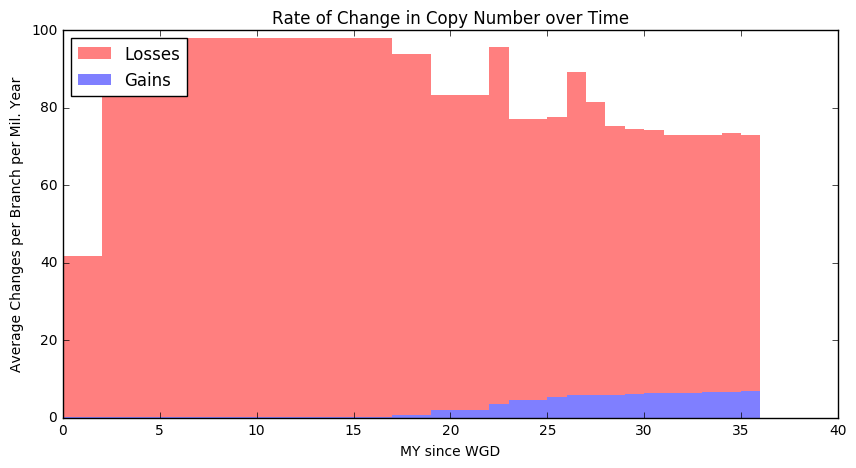

In [105]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def plot_time_histogram(normalized_losses, normalized_gains, start_year=36):
    # plot time_intervals,  plot gains in different colors
    fig, ax = plt.subplots(figsize=(10,5), dpi=100)
    xs = np.arange(0, len(normalized_losses[start_year:]))
    bar_width = 1
    ax.bar(xs, normalized_losses[start_year:], bar_width,
                    alpha=.5, color='r', linewidth=0,
                    label='Losses')
    ax.bar(xs, normalized_gains[start_year:], bar_width,
                    alpha=1., color='#7F7FFF', linewidth=0,
                    label='Gains')
    ax.set_xlabel('MY since WGD')
    ax.set_ylabel('Average Changes per Branch per Mil. Year')
    ax.set_title('Rate of Change in Copy Number over Time')
    # ax.set_xticks(index + bar_width / 2)
    # ax.set_xticklabels(('A', 'B', 'C', 'D', 'E'))
    ax.legend(loc='upper left')
    # fig.tight_layout()
plot_time_histogram(normalized_losses[:-7], normalized_gains[:-7])  

**Conclusion: Simulation does not support lag-time model since it is not a factor included in the simulation parameters.**

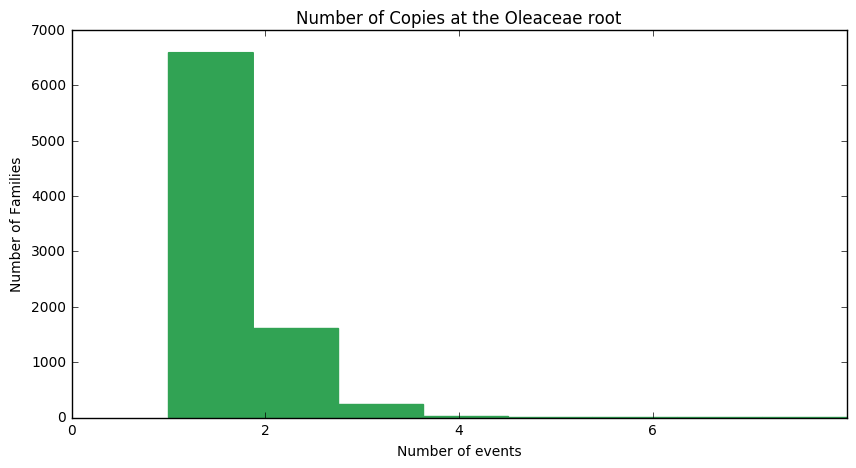

In [22]:
def get_count_at_root(fam_id, ordered_node_index=0):
    newick_str = all_trees[fam_id]
    tree = loads(newick_str)[0]
    for index, node in enumerate(tree.walk(mode="preorder")):
        if index == ordered_node_index:
            count = extract_count(node)
            return count
        
def i_hist(values):
    bins = [0] * (max(values) +1)
    for v in values:
        bins[v] += 1
    return bins

def pretty_hist(title, raw_values, x_title="Number of events", y_title="Number of Families"):
    import pandas
    df = pandas.Series(raw_values)#, columns=['Family ID', 'Copies'])
    bins = max(raw_values)
    f = df.hist(bins=bins, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')#dpi=300)
    f.grid(False)
    f.set_xticks([i for i in range(bins) if i %2 == 0])
    f.set_title(title)
    f.set_xlabel(x_title)
    f.set_ylabel(y_title)

copies = [ get_count_at_root(fam) for fam in all_homeologs]
pretty_hist('Number of Copies at the Oleaceae root', [c for c in copies if c < 21])

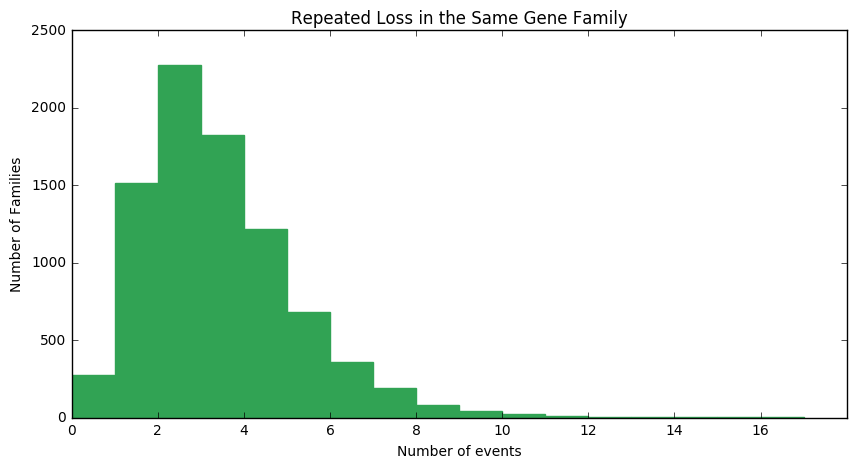

In [90]:
def collect_loss_events_per_family(study_ints, blacklist_index):
    ordered_nodes = create_ordered_nodes()
    loss_events_per_family = {}
    for fam_id in study_ints:
        current_family_loss_events = 0
        species_total = 0
        newick_str = all_trees[fam_id]
        tree = loads(newick_str)[0]
        for index, node in enumerate(tree.walk(mode="preorder")):
            count = extract_count(node)
            if node.ancestor and index not in blacklist_index:
                if not node.name.startswith('_'):
                    species_total += count
                parent_count = extract_count(node.ancestor.name)
                if count < parent_count:  # "loss"
                    current_family_loss_events += 1
                elif count > parent_count:  # gain
                    pass
        loss_events_per_family[fam_id] = current_family_loss_events
    pretty_hist("Repeated Loss in the Same Gene Family", list(loss_events_per_family.values()))
    return loss_events_per_family

all_loss_events = collect_loss_events_per_family(list(all_trees.keys()), [])

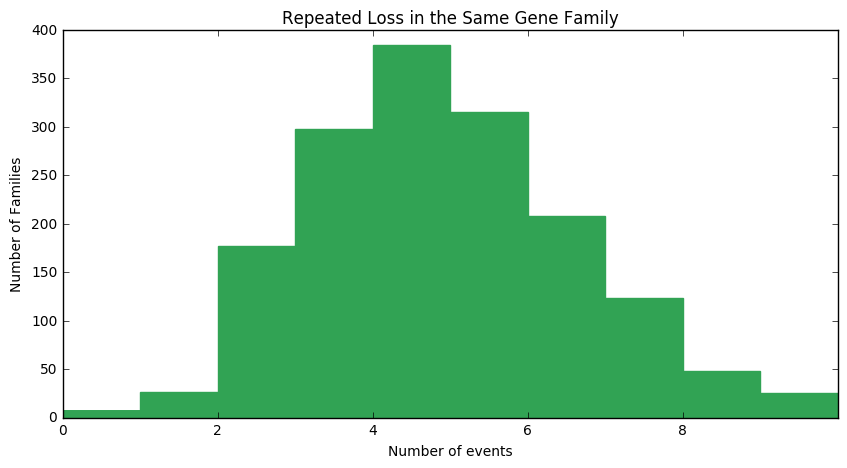

In [24]:
filtered_wgd_study_ints = [fam for fam in all_homeologs if get_count_at_root(fam) == 2]
wgd_study_jsg_losses = collect_loss_events_per_family(filtered_wgd_study_ints, [])

## Categorical Histograms combined

In [103]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def categorical_histogram(title, datasets, normalize=False):
    # plot time_intervals,  plot gains in different colors
    fig, ax = plt.subplots(figsize=(10,5), dpi=1200, facecolor='white')
    hist_series = [[label, i_hist(values)] for label, values in datasets.items()]
    longest = max([len(hist[1]) for hist in hist_series])  
    for i, pair in enumerate(hist_series):
        hist_series[i][1] = (hist_series[i][1] + [0] * longest)[:longest] # zero padding
    xs = np.arange(0, longest)  # set x axis
    bar_width = 1
    cmap = plt.get_cmap("Dark2")
    colors = cmap(np.linspace(0, .3, len(datasets)))

    height_sorted = sorted(hist_series, key=lambda pair: -max(pair[1]))
    tops = [max(pair[1]) for pair in height_sorted]
    for i, pair in enumerate(height_sorted):
        label, bars = pair
        adjusted_bars = [b*(tops[0] / tops[i]) for b in bars]
        if normalize:
            bars = adjusted_bars
        ax.bar(xs, bars, bar_width,
                    alpha=.6, color=colors[i], linewidth=0,
                    label=label)
        
    ax.set_xlabel('Independent Events')
    ax.set_ylabel('Count #')
    ax.set_title(title)
    # ax.set_xticks(index + bar_width / 2)
    # ax.set_xticklabels(('A', 'B', 'C', 'D', 'E'))
    ax.legend(loc='upper right')
    # fig.tight_layout()
    

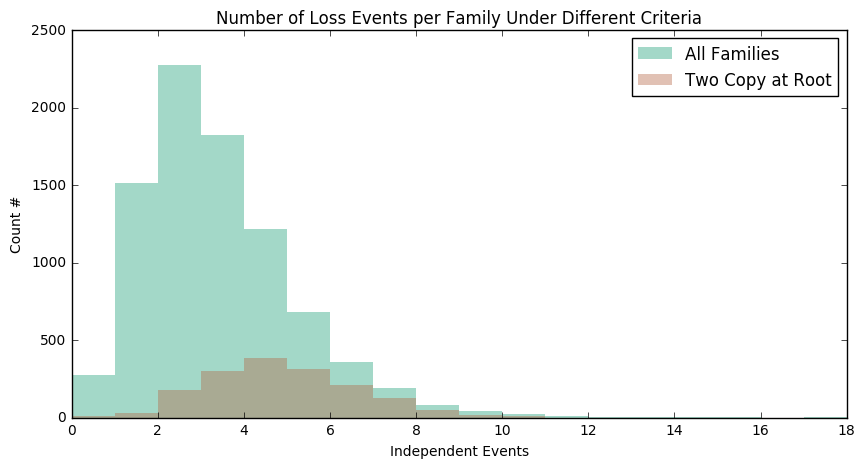

In [27]:
categorical_histogram('Number of Loss Events per Family Under Different Criteria',
    {'All Families': all_loss_events.values(),
     'Two Copy at Root': wgd_study_jsg_losses.values(),
    })

# Comparing simulated and actual observations of Repeatability

In [33]:
actual_losses = [int(x) for x in '3 0 4 3 3 1 0 1 2 3 2 1 0 9 18 2 11 12 0 3 1 7 4 0 3 0 10 6 0 1 2 8 9 4 8 17 6 1 4 5 2 2 1 11 5 1 1 0 1 1 1 7 0 17 12 4 0 3 4 1 1 0 9 2 8 6 0 0 0 10 2 4 2 0 4 2 2 9 1 6 3 0 7 5 12 10 1 0 3 3 4 0 3 0 1 0 0 0 0 1 0 1 2 3 3 2 0 2 2 0 6 0 2 3 0 4 4 3 2 1 1 10 12 10 1 7 17 10 2 3 18 2 9 6 1 3 1 0 2 1 1 2 12 0 2 1 1 11 3 7 4 6 0 4 8 0 12 0 2 10 2 3 2 12 10 1 0 1 4 10 8 3 10 1 0 2 1 2 6 0 2 0 5 2 18 8 13 1 4 5 4 1 13 2 10 2 2 4 2 0 4 14 3 1 5 0 3 2 11 12 2 3 0 1 3 7 0 14 2 4 8 5 8 5 0 10 13 3 4 11 13 1 0 7 1 7 2 3 1 2 2 3 7 1 4 0 7 3 4 3 2 1 1 3 0 10 12 2 1 2 14 0 1 2 2 1 8 6 2 1 2 6 6 2 1 0 6 0 0 3 3 1 5 2 1 3 12 1 2 2 14 4 2 6 1 1 16 0 4 2 0 0 0 4 2 2 7 2 9 10 6 2 6 4 4 0 0 1 15 1 6 1 0 3 4 3 7 0 1 11 1 4 0 5 3 1 2 2 6 1 3 0 7 2 8 10 0 5 9 15 3 4 0 0 3 0 3 1 2 0 12 0 1 1 2 4 1 0 4 8 0 1 11 2 2 3 5 7 10 1 1 10 1 0 5 7 2 2 5 8 0 4 0 2 2 0 7 1 1 0 1 3 5 2 2 4 0 2 11 12 2 1 12 6 7 7 2 1 4 0 1 1 12 0 0 2 1 10 2 6 6 2 14 0 2 3 5 2 2 5 3 2 1 2 7 2 1 2 2 2 3 0 13 1 7 4 1 1 0 0 3 10 1 9 1 3 10 0 17 0 1 2 3 14 0 15 3 13 3 7 2 5 2 16 7 19 5 8 2 5 2 7 0 0 0 4 2 6 1 2 1 14 10 2 17 12 4 3 8 3 1 10 1 5 0 1 2 2 1 2 8 7 5 2 1 1 11 2 2 6 3 1 1 12 1 9 15 6 4 8 8 6 0 3 1 3 4 8 4 5 7 2 10 5 4 13 2 2 2 4 0 13 8 7 1 9 2 0 5 2 5 1 6 3 3 9 9 0 3 1 8 2 2 2 5 2 9 4 2 2 13 3 12 1 10 5 2 0 3 1 1 4 3 3 0 0 2 1 3 2 1 4 9 2 4 5 2 2 3 8 3 1 4 11 5 11 1 1 4 2 1 6 7 6 2 1 2 2 2 6 1 3 14 1 8 4 3 3 12 2 3 2 8 1 1 0 14 2 6 6 1 9 3 2 6 0 2 4 1 2 1 5 8 8 0 2 0 1 3 14 1 3 2 1 5 2 0 2 0 0 5 2 6 0 5 2 0 1 1 1 1 11 5 3 2 3 1 3 1 1 10 4 3 7 8 5 1 2 0 7 2 5 3 2 6 3 14 1 7 8 1 14 4 1 2 1 2 3 2 10 0 12 1 0 7 1 0 2 1 2 2 2 7 3 5 2 2 0 3 1 4 4 6 2 6 6 14 3 1 9 1 9 11 2 4 5 0 4 15 12 1 0 7 4 1 0 4 1 10 3 2 5 0 2 4 5 1 1 8 9 10 2 1 10 15 3 2 7 0 2 3 1 0 15 1 0 5 7 3 1 12 2 4 3 1 1 15 3 2 1 3 0 2 3 1 6 13 11 2 2 3 14 7 9 12 7 5 3 12 10 3 5 1 8 1 5 2 1 1 3 4 1 3 15 9 12 4 1 4 2 3 8 3 3 1 2 2 9 1 4 1 1 2 7 2 10 8 2 0 2 1 0 4 6 10 14 2 3 5 6 2 1 1 8 4 3 2 6 7 8 0 3 4 8 0 6 2 2 0 4 1 1 2 4 1 2 2 2 3 1 1 10 1 4 1 4 13 5 2 2 12 4 5 0 2 3 3 2 2 6 2 0 3 2 3 2 4 2 12 7 5 1 8 6 6 1 3 3 1 4 14 6 2 3 10 16 1 1 11 5 2 8 8 11 11 1 3 3 1 2 3 2 2 0 8 12 1 9 10 1 5 1 0 5 6 2 4 12 8 2 2 4 13 2 1 7 4 3 3 7 6 9 2 4 5 9 0 9 2 5 2 4 2 1 2 2 2 1 3 2 8 0 2 6 2 2 1 7 8 2 3 3 6 0 3 4 3 2 1 3 3 5 5 1 3 9 1 1 6 2 10 2 9 4 8 4 2 1 5 3 2 4 1 5 11 5 2 3 4 9 10 1 5 4 4 4 2 6 1 3 7 1 5 1 5 14 0 2 4 8 4 2 0 9 6 2 16 3 0 2 0 5 1 5 2 2 3 8 5 1 3 4 1 4 1 5 4 4 2 6 7 2 3 6 2 6 13 9 2 1 2 3 4 2 7 1 2 5 3 2 3 4 5 1 2 2 2 5 3 3 1 3 3 3 0 1 0 7 0 14 4 0 2 3 6 3 5 2 2 5 3 8 8 5 2 4 3 1 13 3 2 3 2 7 3 3 2 3 3 0 5 3 6 2 7 3 2 2 13 0 6 1 9 2 7 6 8 3 2 0 5 2 6 9 4 2 5 1 6 5 1 2 4 3 1 2 4 2 0 6 3 8 3 2 8 0 8 0 1 0 3 5 2 8 3 2 2 6 1 1 3 5 3 3 4 1 6 10 4 1 6 3 3 4 3 4 14 5 1 3 3 4 0 4 3 4 4 14 0 1 1 2 0 4 12 1 5 9 2 1 10 4 3 12 0 2 5 6 16 0 3 3 5 11 1 3 4 6 6 5 4 8 3 3 5 4 0 3 2 2 2 5 2 4 2 3 4 7 5 1 2 7 0 4 11 2 3 8 1 6 3 0 10 2 3 3 3 5 3 1 4 1 5 0 3 1 6 5 4 3 2 3 4 12 0 10 2 9 4 1 10 7 6 3 9 4 10 1 11 4 1 8 16 5 3 6 4 0 2 2 5 5 2 3 11 2 5 4 0 15 4 11 5 5 4 3 1 4 3 12 1 4 2 5 7 11 4 12 6 4 2 3 4 4 5 4 0 5 5 6 6 9 1 4 5 13 4 4 5 3 8 1 2 6 1 10 1 10 5 8 8 4 0 4 6 4 4 9 2 12 1 9 0 5 3 4 6 15 5 6 2 4 9 6 1 5 8 4 7 3 1 8 4 10 6 6 6 7 3 6 1 6 9 5 2 5 9 9 6 12 5 4 5 4 2 3 7 5 3 7 4 2 4 0 13 1 7 5 5 4 4 3 4 0 3 6 7 1 6 3 7 5 3 6 1 5 5 6 0 5 8 3 2 0 3 8 6 6 5 4 1 5 4 6 4 1 5 2 11 2 3 1 1 12 5 4 12 2 3 0 2 7 2 2 11 10 6 1 3 3 6 4 7 6 4 19 3 5 4 4 7 5 3 9 2 2 4 2 0 2 9 1 2 4 3 4 5 1 7 0 4 1 6 2 1 3 7 9 4 8 0 5 5 2 2 1 5 14 2 8 7 11 2 3 7 5 5 1 5 7 3 7 3 3 4 6 3 6 7 4 13 3 7 6 0 0 4 2 9 6 3 4 0 3 3 5 13 2 5 4 6 1 4 3 0 12 6 9 1 4 3 4 10 3 0 7 7 6 1 4 4 2 7 2 1 8 2 17 3 1 11 6 6 3 5 3 4 4 4 0 8 7 3 6 5 4 2 7 1 4 3 5 3 8 5 6 6 10 4 8 4 0 4 8 4 5 2 14 12 7 12 6 1 8 1 2 13 6 9 3 2 6 2 4 7 6 9 2 0 17 1 10 3 13 8 4 2 9 10 4 3 2 5 9 11 5 5 5 2 4 6 3 2 2 1 7 0 6 6 3 0 1 7 7 4 5 3 9 6 4 4 1 6 0 6 12 7 4 5 2 4 9 11 12 3 4 6 6 5 2 5 5 5 11 8 2 5 4 2 6 3 5 1 3 4 5 9 0 8 2 9 4 6 7 2 4 4 4 0 4 2 5 3 8 10 1 1 4 8 2 12 2 8 10 8 4 6 4 8 8 6 2 6 4 10 8 1 2 6 7 12 4 7 10 3 5 3 7 16 6 1 7 1 2 8 3 5 6 5 11 2 2 7 0 8 7 11 8 3 7 12 3 1 6 3 7 7 1 15 3 9 4 5 0 8 8 8 2 3 6 3 0 5 0 8 3 10 1 4 1 15 9 9 4 6 7 2 7 6 9 2 6 7 11 19 1 15 1 10 3 7 4 3 3 0 4 1 7 5 13 10 4 2 8 5 9 3 6 2 4 3 0 3 2 0 12 6 6 13 6 10 1 7 5 4 6 10 8 4 3 12 5 6 2 3 5 13 5 7 0 6 9 1 3 8 2 9 9 5 10 0 5 2 5 8 9 3 5 13 11 3 2 7 6 15 6 8 1 2 8 10 7 2 9 8 3 4 4 2 5 2 6 6 6 2 4 0 1 1 3 8 3 2 13 4 3 15 7 1 2 6 9 0 5 3 6 6 11 11 4 12 1 4 8 5 7 13 5 4 7 0 4 7 1 2 0 3 10 3 3 11 16 8 3 1 16 8 2 6 5 4 5 4 4 6 4 12 7 7 1 2 10 20 3 6 6 1 11 2 6 14 7 8 4 7 7 5 5 14 1 8 5 0 5 6 3 8 7 7 5 7 15 13 4 4 3 8 2 7 8 4 2 4 4 4 1 10 11 8 5 11 4 8 9 6 4 1 6 1 7 9 9 1 9 6 3 11 15 2 10 11 1 5 3 3 9 2 4 14 3 2 5 7 5 7 6 3 5 1 1 5 10 7 18 6 6 1 9 7 4 4 9 9 7 15 17 16 11 3 9 19 2 4 5 14 7 5 1 8 3 7 7 13 9 10 10 1 9 9 4 4 6 11 8 2 15 1 7 7 15 11 4 7 10 5 4 6 6 2 2 6 3 11 6 16 5 7 12 5 9 4 6 8 3 3 2 2 5 3 13 18 6 3 2 2 8 5 7 6 3 7 3 7 9 7 2 6 10 10 5 4 8 5 6 12 1 12 4 2 5 3 13 0 11 7 21 9 7 3 3 4 9 7 3 13 2 2 2 10 3 9 14 5 5 4 6 6 6 2 9 6 10 6 7 6 3 6 7 5 4 4 13 0 8 9 9 5 10 12 2 8 8 16 5 4 0 6 3 11 5 4 8 1 7 8 2 8 12 13 6 2 8 4 10 7 4 7 8 2 4 4 6 2 12 7 17 10 10 5 9 8 4 13 2 8 2 7 10 4 6 9 5 13 7 13 10 4 13 13 4 5 10 12 10 4 2 4 7 9 12 3 6 12 1 5 6 2 12 9 5 11 4 11 2 10 5 3 6 9 5 17 9 14 9 2 10 7 5 5 7 7 5 12 5 10 5 11 10 8 6 8 8 5 2 8 8 7 8 4 3 9 10 7 8 8 6 9 0 4 5 2 9 17 13 3 8 15 3 15 13 2 2 6 1 6 9 9 6 4 7 3 2 10 2 4 6 11 13 8 15 1 12 4 12 8 2 3 6 6 2 1 5 9 3 4 5 7 7 7 4 3 1 11 6 10 0 14 5 5 6 0 2 0 7 6 4 7 3 7 12 3 2 8 4 12 15 17 8 14 3 8 3 5 7 9 3 11 11 2 6 11 7 4 3 4 9 9 7 6 10 6 2 13 1 10 2 1 1 6 6 6 16 10 10 9 8 6 6 3 15 5 10 2 10 3 8 0 4 2 12 5 17 4 8 13 8 2 8 10 5 7 8 7 5 6 4 6 11 3 1 6 4 12 13 14 2 3 7 4 6 3 5 6 6 17 2 13 3 8 4 7 12 10 2 8 3 2 7 2 10 16 3 5 11 3 10 15 2 5 2 3 8 8 6 2 5 3 2 2 2 5 6 3 7 9 15 8 4 8 7 0 6 6 2 10 8 7 10 7 1 3 7 6 16 18 16 9 10 11 5 3 7 11 15 3 8 12 5 12 2 9 11 2 15 13 7 12 9 9 8 11 8 10 7 8 10 7 10 10 1 3 0 9 11 7 3 2 3 3 2 0 0 10 14 12 4 10 2 9 4 9 7 10 9 17 7 14 12 5 7 3 8 3 12 6 9 12 9 3 13 12 8 13 5 4 3 7 8 14 9 6 9 6 14 12 7 5 7 2 9 11 2 8 12 7 4 4 6 13 2 3 8 17 10 13 3 6 8 2 9 12 5 6 11 16 5 5 5 9 14 10 13 10 1 5 13 6 8 7 16 3 2 5 10 8 6 14 2 10 15 5 2 13 8 2 12 7 10 8 4 11 6 6 5 14 8 1 14 6 8 11 10 9 5 15 7 8 8 1 2 9 2 9 9 3 2 12 6 10 5 8 16 11 0 12 12 14 8 3 2 7 8 8 11 2 8 5 6 8 5 4 13 1 0 2 12 7 2 10 14 6 3 8 12 6 8 6 8 3 4 5 10 1 10 15 1 2 8 11 7 10 8 6 9 10 6 2 7 10 9 7 10 5 12 13 2 3 5 13 4 9 15 14 1 16 8 12 8 2 13 6 9 3 9 6 7 6 5 13 8 8 13 11 10 7 12 9 9 10 13 2 13 8 3 15 17 3 3 13 17 8 15 8 13 2 9 10 10 3 16 10 14 12 7 2 8 0 10 7 7 2 1 7 12 12 11 7 6 7 22 6 2 6 8 7 11 6 9 8 1 8 11 10 12 9 8 2 17 5 6 2 5 11 5 14 12 16 1 14 6 18 4 8 10 5 9 1 6 12 2 2 10 3 6 9 12 5 5 0 9 8 11 2 13 8 12 15 6 7 6 7 6 5 15 12 2 10 3 4 4 11 16 11 8 3 5 4 3 5 11 8 12 8 10 5 3 8 11 7 3 5 8 5 15 7 10 6 12 14 13 15 4 5 1 12 9 8 10 7 5 1 15 3 6 5 8 4 5 11 8 4 2 5 2 10 15 12 2 5 8 0 3 3 14 12 2 2 4 4 7 10 0 6 13 2 8 12 15 10 12 13 12 12 8 0 7 10 1 2 13 7 5 6 16 9 11 9 2 7 3 12 9 15 14 3 0 1 10 12 8 7 2 10 3 12 5 5 9 7 13 2 4 0 0 17 2 15 2 7 9 14 7 7 4 4 5 11 8 11 5 2 10 5 2 7 6 2 9 8 5 16 7 4 4 8 2 6 8 14 13 6 12 5 2 13 8 8 20 12 3 2 0 5 1 8 6 11 7 10 13 11 19 6 10 8 13 15 9 17 9 8 4 10 9 9 3 1 8 9 9 10 0 6 0 1 8 2 9 5 17 14 11 15 5 6 14 1 15 12 0 7 10 1 4 1 5 11 0 2 3 5 9 1 6 5 10 10 10 8 17 7 11 9 1 14 14 6 2 6 9 16 7 10 11 11 17 6 12 3 10 15 6 10 6 5 7 4 8 11 0 5 4 13 2 11 1 14 9 8 17 5 8 1 17 6 11 7 7 0 16 13 2 13 17 14 9 7 2 9 7 3 2 3 15 8 6 5 9 2 3 8 11 2 4 7 8 14 4 6 11 5 10 7 4 6 13 13 13 10 0 15 6 7 0 15 2 13 9 9 7 10 8 14 5 4 10 1 18 16 4 13 5 0 13 6 10 13 4 14 14 13 1 11 4 2 11 16 2 16 5 12 2 6 14 16 13 6 11 15 6 2 5 8 9 9 4 2 18 14 10 7 8 0 11 9 5 17 0 0 2 13 3 8 0 9 11 14 5 4 6 1 13 5 7 2 4 6 12 13 2 1 4 18 9 8 7 10 7 11 5 5 11 12 2 4 1 9 8 10 3 8 8 13 1 7 1 10 8 9 12 4 4 8 8 7 11 6 5 10 0 14 4 12 6 4 9 4 4 9 2 11 5 4 1 4 10 10 9 5 4 8 15 7 7 9 12 2 4 5 6 17 8 14 13 1 2 10 0 9 1 1 8 12 1 10 2 11 7 1 3 9 14 7 5 0 4 11 8 5 17 2 0 16 6 16 5 6 3 12 2 6 10 7 11 7 15 4 9 3 6 1 3 3 17 3 5 14 13 7 5 10 0 8 4 3 2 11 11 3 6 5 11 11 3 3 10 2 16 5 4 9 12 7 2 15 7 7 2 4 1 13 6 9 10 1 2 11 2 9 8 14 4 1 5 1 1 10 10 8 6 3 0 0 2 12 5 13 10 9 8 12 6 0 8 18 9 2 7 9 0 10 15 11 10 10 0 4 6 6 5 2 7 2 7 2 13 14 2 18 0 8 19 10 8 11 13 4 1 8 7 8 9 11 1 3 2 3 2 0 1 5 9 8 17 3 14 6 7 8 12 1 2 3 5 5 6 2 2 12 0 10 0 16 6 16 7 3 13 11 5 15 6 6 10 5 2 7 3 7 13 8 3 7 0 2 6 10 15 0 8 9 6 10 7 1 2 7 5 3 15 7 4 9 2 7 10 10 3 7 4 6 15 3 9 1 8 9 7 5 1 1 3 11 10 2 4 3 12 1 5 8 11 2 9 7 2 7 3 5 4 5 2 4 2 2 4 3 2 20 12 10 11 13 10 2 6 4 0 2 1 4 14 2 7 0 9 4 9 11 7 5 11 1 11 2 5 9 9 13 7 5 2 7 13 10 10 4 9 2 6 8 2 2 7 9 15 4 2 8 6 1 4 10 9 8 13 6 1 4 7 0 4 14 6 8 11 7 10 3 8 8 5 2 4 6 3 0 8 8 1 0 7 12 1 11 3 9 11 1 6 12 0 8 8 7 6 0 2 4 3 10 12 2 2 4 6 8 13 6 9 1 4 10 3 4 6 2 15 0 2 7 9 6 9 10 0 3 6 3 12 2 4 7 0 6 6 6 8 8 1 11 11 1 15 9 0 10 2 3 0 2 3 12 2 7 9 11 1 1 1 8 16 11 13 11 2 5 11 7 16 16 14 10 5 2 12 2 7 2 5 4 7 0 0 8 13 2 6 12 8 5 12 6 4 0 7 3 2 5 2 9 15 2 0 10 4 14 7 2 6 12 14 8 11 6 9 8 9 13 1 14 15 5 5 9 9 6 3 5 1 9 1 15 3 3 8 7 4 2 5 11 13 7 9 13 4 5 2 7 2 14 18 12 10 15 3 4 15 11 7 3 7 12 3 13 6 5 5 2 9 16 9 5 13 8 14 8 8 15 9 7 19 2 5 5 10 0 5 9 11 9 8 14 6 14 10 17 5 2 0 13 16 5 6 12 2 9 2 4 0 5 2 10 10 11 6 12 1 14 7 7 4 3 3 1 2 7 10 5 9 13 11 9 13 5 2 5 9 13 10 2 8 14 10 0 9 0 17 5 8 8 6 4 3 11 8 11 7 6 9 0 6 9 12 2 2 14 14 1 2 7 1 16 14 11 6 11 2 5 2 3 12 5 0 1 6 7 2 3 14 0 12 2 6 7 9 3 1 7 6 3 5 2 6 5 4 7 3 2 9 0 11 3 3 3 8 5 2 0 6 9 2 9 9 5 9 7 8 3 8 9 8 4 12 1 11 6 4 16 12 15 9 10 4 3 4 12 13 13 2 8 14 9 9 12 7 20 1 3 15 10 3 14 10 15 14 6 7 3 10 0 8 9 8 9 8 2 11 3 9 2 7 6 12 9 8 11 3 9 14 3 8 12 9 8 8 9 7 8 7 5 7 3 15 10 0 0 13 3 0 3 9 8 2 1 13 2 0 6 2 1 0 9 4 2 12 11 2 2 14 5 2 5 9 14 8 11 9 1 1 0 5 17 12 5 12 8 1 3 3 2 15 5 8 7 2 2 15 9 4 0 0 0 12 2 14 12 15 0 13 0 11 11 0 12 3 8 3 5 8 5 7 0 3 0 0 1 10 0 4 1 16 11 1 12 11 0 1 4 16 2 14 4 5 0 8 1 2 15 5 2 12 2 3 4 2 8 2 6 6 0 2 16 8 3 0 2 0 1 6 2 2 5 2 1 9 4 5 2 4 0 0 1 1 1 11 3 9 0 0 1 12 2 3 2 0 2 0 2 1 2 3 0 7 13 0 2 1 11 1 0 11 0 7 6 4 12 12 8 6 6 2 3 14 15 2 0 10 3 0 0 7 7 0 2 3 0 9 1 0 16 8 10 1 5 4 8 3 0 9 8 5 11 2 16 15 0 2 7 6 14 0 11 0 0 15 3 5 13 0 7 2 8 11 7 4 0 0 6 16 1 8 5 12 6 3 3 3 1 4 5 13 8 15 3 1 4 1 7 5 9 10 2 4 0 9 4 2 14 8 9 0 0 11 1 1 0 10 1 5 4 18 1 0 3 2 8 2 3 2 2 13 3 1 0 0 2 2 0 15 0 0 0 15 0 2 0 0 4 0 12 12 3 9 2 12 3 1 0 5 0 3 1 11 1 7 14 3 2 9 2 2 0 0 0 1 1 3 1 0 2 13 0 9 6 6 21 2 10 3 3 8 1 0 2 13 2 6 4 1 2 8 0 3 0 1 0 17 3 0 13 9 2 0 17 2 0 3 12 0 0 3 4 2 2 0 5 7 2 12 4 10 0 0 0 1 3 0 0 0 0 7 3 13 12 0 5 3 3 3 13 5 5 2 12 5 3 0 0 8 8 13 2 2 0 5 9 2 2 12 8 0 1 1 13 0 5 13 3 6 5 0 0 2 0 0 0 0 0 1 3 0 0 6 13 15 0 5 6 3 0 1 4 5 0 6 3 0 19 0 10 0 0 2 2 1 3 0 1 7 2 0 1 10 1 0 3 1 2 3 3 1 6 15 4 11 1 11 2 1 0 0 0 0 0 2 1 4 2 1 0 1 3 1 0 2 0 0 4 1 1 3 9 0 0 3 0 0 0 4 0 2 12 3 2 2 3 4 0 0 3 1 1 1 0 2 7 1 6 4 8 5 8 5 1 3 1 3 0 6 4 1 3 2 4 3 0 9 9 1 0 15 1 0 0 1 0 0 0 4 1 0 0 1 0 0 7 1 1 10 4 6 1 0 1 1 2 3 1 0 0 2 6 5 11 3 0 2 3 14 0 1 5 2 5 1 1 4 3 2 1 0 1 5 6 3 0 0 9 2 1 15 1 2 4 4 5 1 0 2 10 3 14 8 1 0 1 3 1 1 4 1 1 0 0 1 1 4 3 1 2 11 0 1 1 14 2 2 3 0 2 1 0 1 1 1 2 14 0 14 11 0 1 1 10 2 1 2 17 1 11 9 0 0 2 5 12 3 9 13 5 0 1 2 2 10 2 4 10 3 5 2 4 5 1 0 4 1 1 0 0 6 2 5 3 0 8 1 5 1 1 0 5 1 0 5 9 0 3 0 7 3 0 1 4 3 2 1 0 3 3 0 2 1 1 4 2 1 3 7 4 17 3 0 3 3 0 0 2 0 1 2 0 3 15 12 5 1 1 0 0 3 2 2 0 3 10 1 1 0 1 0 0 3 0 9 0 0 6 0 3 13 3 6 0 1 8 4 0 15 0 3 1 2 7 11 5 0 10 3 2 13 8 12 1 0 1 0 2 2 1 3 9 3 4 7 1 3 1 0 0 2 10 17 2 1 0 1 5 5 2 1 11 1 0 1 2 0 2 4 2 0 1 12 0 9 8 4 1 0 0 1 6 2 2 5 3 8 1 1 5 0 0 9 2 9 1 7 11 3 1 1 4 0 2 1 4 3 2 5 3 6 0 15 2 7 1 12 0 0 5 0 6 0 3 4 1 1 11 0 8 6 0 1 1 0 1 0 2 0 4 8 13 1 3 7 16 2 3 4 1 1 4 1 0 2 1 1 17 0 1 3 3 10 1 3 6 9 2 2 3 1 1 3 9 0 4 0 3 3 1 8 3 6 8 4 6 1 1 2 1 1 1 4 2 1 0 9 0 6 2 1 2 9 0 7 3 8 1 0 2 14 2 0 6 1 2 2 6 6 0 0 10 2 3 3 1 5 9 4 3 3 1 0 1 0 1 0 15 2 2 13 10 4 1 10 7 0 3 1 0 6 1 2 4 2 0 3 4 6 0 2 2 9 3 0 4 13 1 9 0 5 3 4 1 4 4 12 1 0 1 3 4 4 1 9 2 2 2 2 1 0 5 1 1 0 0 0 16 1 2 2 3 2 1 2 1 1 1 2 5 0 7 4 9 4 3 2 4 1 1 3 0 12 1 7 3 9 4 4 6 0 4 2 3 1 9 2 1 3 16 2 7 7 1 6 1 6 5 8 2 0 2 5 15 1 0 8 3 2 7 1 13 1 3 2 2 1 2 5 1 3 4 1 3 6 16 12 0 2 1 1 0 5 3 7 3 1 0 9 2 5 3 2 8 2 7 4 1 1 10 11 4 4 14 3 1 2 3 2 1 1 3 4 2 10 5 4 1 2 1 3 3 7 5 6 0 3 8 1 1 5 0 5 3 2 2 3 4 3 4 7 2 5 1 0 6 0 0 2 2 1 4 4 2 2 16 1 2 3 4 5 13 2 6 5 2 10 1 2 11 7 5 6 3 2 0 2 1 6 5 3 3 1 2 0 1 3 4 2 6 9 4 1 11 3 12 0 2 0 2 5 4 13 2 8 9 0 1 13 11 4 2 4 6 2 0 1 13 10 3 6 8 21 6 6 2 16 14 2 3 6 2 0 2 10 13 2 1 2 9 3 3 11 0 2 3 2 0 4 2 2 2 2 3 3 5 3 3 1 11 1 2 3 2 4 1 4 2 8 5 12 5 3 2 3 2 10 0 1 9 11 14 3 1 2 4 8 1 6 4 1 2 2 4 0 11 6 6 1 8 7 5 0 5 13 8 0 3 4 2 5 13 4 3 4 4 4 0 5 0 1 1 2 5 3 12 16 2 5 1 4 4 1 8 8 1 5 3 0 3 12 6 10 1 2 6 0 3 11 2 4 6 3 4 1 6 4 0 2 11 5 4 2 3 1 3 1 2 15 14 7 1 4 5 2 1 11 10 6 2 3 1 2 6 4 8 5 12 4 1 4 8 2 3 2 13 7 3 4 5 5 2 7 9 3 6 1 3 3 5 2 9 1 4 4 5 3 2 1 6 5 3 1 4 1 6 3 2 9 0 5 4 1 3 4 4 1 3 0 3 5 8 8 6 2 13 1 17 9 0 14 2 2 2 5 3 2 10 8 9 5 9 5 4 12 4 7 3 14 13 12 8 7 10 0 2 16 6 8 1 0 3 6 3 6 7 5 12 4 2 7 2 2 4 2 14 1 3 1 14 11 9 2 5 2 1 9 7 6 0 1 5 2 2 5 1 8 13 11 1 3 6 1 4 4 5 12 5 3 7 2 2 8 1 2 1 12 0 7 0 0 3 4 0 7 5 0 3 6 4 12 2 12 1 2 1 2 3 11 13 7 6 6 3 1 12 2 9 1 4 16 2 5 2 4 1 5 14 13 4 7 1 3 1 0 2 3 2 1 5 3 2 2 8 8 3 4 12 3 15 10 7 1 4 12 9 2 7 9 6 3 5 6 2 5 4 5 8 11 5 2 3 11 2 1 4 4 4 2 1 7 5 12 9 2 0 2 6 6 10 9 5 5 2 6 10 1 2 9 3 2 8 0 2 4 9 3 6 3 9 0 5 3 1 0 3 3 3 13 3 3 12 9 4 10 1 2 0 2 3 2 0 0 1 3 3 3 5 13 2 6 6 17 2 1 3 12 6 1 14 2 2 6 5 5 8 3 1 1 6 2 8 4 0 3 6 8 6 2 0 9 12 4 4 5 4 1 4 10 5 1 3 7 5 4 10 4 10 3 8 2 5 3 2 4 4 0 5 7 5 3 5 4 6 6 2 2 7 1 14 14 0 2 4 2 1 4 6 2 3 5 5 3 3 13 0 14 1 0 0 6 1 4 3 3 2 2 5 2 5 15 4 2 4 5 7 8 3 5 8 5 2 0 2 2 6 11 4 1 7 3 3 0 2 13 2 2 18 9 6 4 3 6 7 4 4 3 2 9 1 3 3 8 2 7 2 3 5 1 1 2 6 13 1 4 13 7 4 1 0 6 2 5 0 7 6 3 2 6 5 8 0 7 3 12 2 10 12 1 5 8 3 4 5 8 9 5 3 4 5 14 1 4 2 3 11 8 14 12 9 5 7 11 8 18 13 10 0 5 8 5 6 3 8 16 3 9 7 12 11 13 0 11 3 3 3 2 3 4 2 5 2 2 0 2 10 18 6 1 3 3 6 7 1 5 2 11 8 0 4 4 4 8 3 13 14 8 5 9 7 6 1 10 13 3 3 5 2 10 0 0 12 10 4 6 14 0 2 6 9 2 8 6 7 17 2 16 4 2 11 10 3 5 2 14 5 3 10 1 6 8 9 8 2 17 10 7 7 4 17 3 1 3 10 7 12 8 1 7 13 13 8 9 2 9 12 5 6 16 5 10 2 3 4 4 6 3 1 5 5 6 11 0 2 5 6 3 7 9 5 2 10 3 4 3 4 4 3 1 3 15 2 5 1 3 2 4 2 3 9 1 0 4 5 4 6 2 3 3 9 10 16 6 0 2 7 4 11 0 2 5 2 3 6 4 8 8 8 4 12 4 7 2 0 5 15 4 6 7 1 0 0 7 3 3 16 5 9 11 5 4 2 1 4 11 13 3 1 5 4 1 2 3 3 4 5 8 5 7 17 0 17 6 7 0 0 10 2 4 3 2 3 1 4 4 3 13 1 14 13 2 2 4 1 4 3 9 4 4 2 3 7 4 0 2 3 10 3 6 4 3 0 8 15 0 5 2 11 15 4 1 10 3 3 2 15 5 4 2 2 2 4 8 0 1 4 3 12 5 1 13 10 9 6 2 12 4 7 3 5 1 12 2 5 7 0 7 5 2 6 3 4 6 2 3 2 6 4 3 7 3 12 2 11 0 7 2 8 4 13 6 3 6 2 5 14 3 4 4 3 6 5 13 9 2 11 6 6 5 8 8 11 6 5 4 1 4 4 3 3 1 8 4 2 7 8 17 11 9 9 5 17 15 3 6 2 2 1 9 3 3 3 4 4 7 2 4 14 3 3 7 8 5 4 8 4 5 4 2 5 2 3 3 2 13 1 0 3 2 4 11 10 15 1 4 10 4 8 1 1 11 4 12 2 13 0 7 3 11 7 5 3 15 5 3 14 2 12 3 7 3 11 11 4 1 2 5 9 2 8 5 0 8 12 1 4 4 16 6 9 5 4 2 2 4 2 5 5 5 6 4 4 9 9 6 4 5 7 6 16 16 0 6 11 16 5 3 4 6 10 4 1 1 0 7 2 16 7 3 5 5 7 6 6 4 4 1 4 1 4 6 4 2 9 1 12 1 4 7 7 0 6 3 14 7 5 7 9 12 2 9 8 1 6 6 7 5 4 7 3 2 3 7 2 13 7 8 0 6 4 0 2 3 14 3 5 0 9 4 5 6 11 16 5 15 5 1 5 2 7 5 9 11 2 16 3 4 8 4 3 4 3 10 4 3 9 9 9 10 5 11 2 6 6 4 3 10 6 3 2 11 8 9 2 13 1 2 8 19 8 11 8 13 3 2 4 4 7 11 5 3 9 9 9 8 11 2 7 4 1 5 7 3 6 6 6 11 14 2 11 8 10 4 13 13 7 2 3 8 9 5 9 5 2 13 9 8 3 3 4 6 2 6 5 3 9 11 6 15 5 4 5 2 0 13 2 3 11 8 2 5 7 4 7 6 2 1 12 2 6 15 11 0 10 2 4 9 7 16 9 4 5 11 5 6 15 5 1 2 4 8 5 10 11 4 12 10 13 3 1 5 12 11 2 2 6 8 11 3 12 4 6 9 10 10 11 13 11 8 9 8 11 6 4 14 7 7 3 4 4 3 3 12 10 3 10 8 2 12 0 14 10 12 9 5 13 11 3 12 4 10 3 3 2 8 0 7 13 2 12 14 6 13 12 10 9 8 5 2 2 13 5 9 5 11 2 11 14 2 5 8 4 14 2 7 6 9 0 7 4 2 3 12 14 11 5 12 6 10 0 9 4 11 2 4 4 10 6 5 3 9 1 12 4 10 6 0 5 8 11 2 3 7 16 9 12 8 0 5 1 8 15 4 2 12 7 9 0 16 6 6 7 6 1 0 12 5 14 15 6 7 10 8 9 1 4 9 7 12 7 18 5 5 14 8 9 4 3 2 4 11 8 11 5 13 8 4 9 6 7 7 2 4 10 9 10 8 4 5 11 0 12 0 6 6 5 1 6 2 6 2 2 8 7 9 2 12 8 10 5 2 10 15 8 1 7 4 8 4 14 6 4 7 7 8 4 7 5 15 6 2 5 5 9 17 8 2 5 0 15 2 2 4 6 6 7 3 2 2 9 9 12 16 12 17 15 3 2 13 9 11 11 9 9 6 4 4 9 5 8 4 8 9 12 15 2 2 5 6 2 18 2 6 1 3 9 5 4 5 15 18 8 2 5 8 5 5 11 4 8 5 8 9 8 9 2 12 6 9 7 1 4 11 4 12 16 11 0 7 5 13 5 7 10 11 14 6 3 14 11 18 9 8 9 7 2 10 3 2 2 9 6 5 2 7 13 8 10 6 6 4 11 10 8 4 5 13 8 9 9 7 10 6 1 8 4 4 1 6 7 9 9 5 16 5 10 5 2 4 6 2 2 8 8 9 9 10 2 8 5 6 0 11 0 4 4 2 8 9 8 0 14 4 2 5 16 14 15 8 16 2 8 3 6 4 1 7 9 12 6 9 6 11 12 1 13 9 6 2 9 1 15 5 10 0 8 8 4 16 14 18 2 4 7 8 5 7 15 6 11 7 5 2 6 8 7 11 7 2 11 7 1 6 13 16 4 2 7 6 5 2 7 14 8 3 8 2 9 10 7 7 6 4 4 10 4 3 3 6 8 8 2 6 6 9 10 12 9 6 2 1 9 3 8 12 2 2 11 7 2 3 7 3 10 7 14 5 11 7 7 7 2 2 6 5 11 2 5 10 12 0 14 4 3 7 10 2 5 5 8 6 7 10 14 8 12 2 5 0 3 7 3 9 12 4 2 13 5 12 2 12 2 15 7 8 2 1 6 5 7 12 1 5 2 5 8 2 10 4 2 7 8 15 4 12 7 1 7 3 2 1 2 8 4 4 2 9 5 6 4 7 4 11 2 5 14 1 17 4 11 3 0 12 8 3 15 14 12 4 3 9 6 2 2 9 7 0 11 0 16 2 2 5 3 6 5 7 1 10 9 9 1 6 13 6 12 2 12 2 7 1 2 7 5 11 8 0 6 7 9 9 6 0 8 6 2 1 3 14 9 2 9 10 3 2 4 7 5 12 5 2 9 11 6 15 7 4 5 7 2 14 6 5 11 0 2 2 10 8 3 12 2 9 9 1 4 10 7 10 0 13 4 12 7 3 1 9 2 3 1 9 2 8 3 11 6 8 2 3 12 10 2 6 1 2 2 2 9 8 6 0 8 15 2 8 11 13 11 6 7 8 9 6 3 6 14 1 8 0 8 1 10 2 10 16 4 19 12 5 9 6 2 9 0 12 0 7 9 12 2 11 8 11 9 8 6 7 8 9 8 8 4 6 0 17 9 13 8 8 12 0 6 4 15 13 9 3 11 11 0 13 13 5 5 7 2 0 2 6 1 10 9 10 10 7 4 9 3 7 0 11 4 1 6 4 1 6 5 3 3 8 7 1 10 1 0 14 11 5 6 8 7 0 2 7 11 6 11 6 10 17 8 11 12 2 8 0 6 5 1 8 2 0 9 5 3 0 2 9 3 0 1 13 15 7 4 15 3 7 3 9 13 4 7 2 2 4 4 0 10 6 3 0 0 2 0 3 11 7 5 4 3 10 2 5 0 1 3 2 11 3 1 9 2 3 11 12 18 9 0 0 8 10 3 8 0 2 9 3 6 4 0 15 1 0 2 1 0 0 6 12 7 9 3 2 15 10 13 4 10 10 0 2 14 0 10 3 1 11 12 3 7 13 5 6 7 14 1 8 3 2 3 0 15 0 6 1 5 2 5 5 4 1 3 0 12 0 0 7 0 12 12 0 0 12 13 5 2 1 2 9 4 2 6 5 10 2 5 10 14 2 2 7 2 6 4 10 12 3 13 11 10 9 8 1 0 8 2 1 9 6 9 12 8 12 8 2 0 1 9 4 11 9 4 3 9 13 8 11 0 10 1 1 0 5 5 0 19 11 11 9 9 6 16 0 7 0 3 0 4 0 19 11 9 17 0 6 0 5 8 7 11 13 5 6 18 13 8 12 10 9 5 2 4 4 0 8 4 0 9 1 7 2 3 5 1 7 10 1 10 3 8 5 7 0 14 4 0 8 3 6 8 3 6 13 5 0 5 4 6 13 9 12 12 12 4 0 13 6 1 3 2 0 2 2 9 3 0 10 1 1 4 6 5 2 10 8 8 3 9 0 9 1 5 2 1 2 6 4 9 3 0 15 2 12 15 14 1 2 1 11 13 1 0 16 0 1 1 3 6 6 3 9 0 3 7 1 2 14 1 2 5 2 9 6 9 9 7 0 4 8 5 0 2 12 0 13 13 1 9 4 5 0 10 0 0 3 15 0 2 1 2 9 12 2 9 1 0 0 8 2 3 8 2 16 4 3 2 4 8 1 10 6 13 12 3 1 0 0 0 2 0 8 3 0 3 4 2 5 0 14 1 6 11 13 1 0 12 2 6 9 4 9 2 2 0 5 0 10 18 4 0 1 13 12 7 1 11 0 1 2 7 2 4 7 5 0 13 0 7 11 3 0 0 13 1 10 7 0 0 1 8 5 11 2 15 1 8 4 2 4 0 6 2 7 2 6 10 4 6 18 2 0 2'.split()]
len(actual_losses)

8485

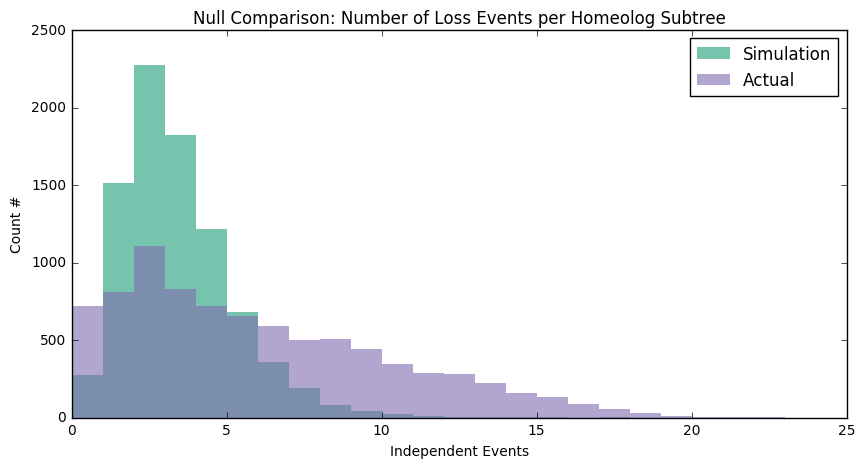

In [104]:
categorical_histogram('Null Comparison: Number of Loss Events per Homeolog Subtree',
    {'Actual': actual_losses,
     'Simulation': all_loss_events.values(),
    })

In [78]:
from scipy.stats import wilcoxon, ranksums
test = ranksums(actual_losses, list(all_loss_events.values()))
test

RanksumsResult(statistic=38.34216773579043, pvalue=0.0)

**Conclusion: Simulated and actual distribution are different beyond doubt.**

In [102]:
ranksums(actual_hist, sorted(sim_hist)) == ranksums(actual_hist, sim_hist)

True

Conclusion: This function is not sensitive to order

# Intersecting Sets of Polyphyletic losses within Homeolog subtree

In [106]:
from scipy.stats import hypergeom

def simple_overlap_prob(A, B, all_possible, verbose=True):
    intersect = len(set(A).intersection(set(B)))
    if verbose:
        print(pp(len(A)), "overlapping with", pp(len(B)), "by", pp(intersect),"in a space of size", pp(len(all_possible)))
    return min(1, hypergeom.sf(intersect-1, len(all_possible), len(A), len(B)))  # pval assuming even distribution

In [107]:
species_names = [node['name'] for node in ordered_nodes if not node['name'].startswith('<')]  # 
probs = dict()
from statistics import mean, median
# All pair wise combintations once
for x in range(len(species_names)):
    for y in range(x+1, len(species_names)):
        intersect = genes_lost[species_names[x]].intersection(genes_lost[species_names[y]])
        print(species_names[x], species_names[y], len(intersect), end=': ')
        prob = simple_overlap_prob(genes_lost[species_names[x]], genes_lost[species_names[y]], all_homeologs, verbose=False)
        probs[(species_names[x], species_names[y])] = prob
        print(prob) #TODO probability

FRAX30 FRAX32 0: 1
FRAX30 FRAX28 5: 0.3099411313974801
FRAX30 FRAX12 9: 0.16039259370704823
FRAX30 FRAX07 12: 0.2735574992861902
FRAX30 FRAX29 12: 0.2810643919551674
FRAX30 FRAX08 24: 0.013836958101706948
FRAX30 FRAX01 0: 1
FRAX30 FRAX16 2: 0.762785659923543
FRAX30 FRAX15 12: 0.04304411121337567
FRAX30 FRAX00 10: 0.5072467561487642
FRAX30 FRAX06 10: 0.5525007524815173
FRAX30 FRAX23 17: 0.0317495363546503
FRAX30 FRAX25 29: 0.0005847156289388354
FRAX30 FRAX21 33: 0.0036420323413271175
FRAX30 FRAX19 6: 0.868440790577049
FRAX30 FRAX20 10: 0.3783428276984353
FRAX30 FRAX11 5: 0.6839351725881048
FRAX30 FRAX27 2: 0.9751123013312379
FRAX30 FRAX04 8: 0.8271712388603346
FRAX30 FRAX03 0: 1
FRAX30 FRAX09 1: 0.7092857795249152
FRAX30 FRAX13 2: 0.6451194880755167
FRAX30 FRAX26 7: 0.01687924336913168
FRAX30 FRAX14 3: 0.42097889476990996
FRAX30 FRAX05 3: 0.9908080300039532
FRAX30 FRAX33 14: 0.19818773612905818
FRAX30 FRAX31 49: 0.633719328162373
FRAX30 Oeuropea 52: 0.31157632523999557
FRAX32 FRAX28 6: 

In [118]:
print(pp(len([c for c in probs.values() if c < .00001]) / len(probs)), "of", len(probs), "species pairs have significant overlap.")

2.955665% of 406 species pairs have significant overlap.


In [112]:
print(round(406 * .02955665), "pairs were significant and we can safely discard up to 30 pairs as being sister species.")

12 pairs were significant and we can safely discard up to 30 pairs as being sister species.


**Conclusion: Simulated data shows no significant overlap.**